In [1]:
import stompy.model.delft.dflow_model as dfm
import numpy as np
import pandas as pd
import xarray as xr
from stompy.grid import multi_ugrid
import os
import six
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
six.moves.reload_module(dfm)

<module 'stompy.model.delft.dflow_model' from '/home/rustyh/src/stompy/stompy/model/delft/dflow_model.py'>

In [3]:
fig_dir="fig-scenarios-20220722"
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [4]:
import run_database
six.moves.reload_module(run_database)
all_runs=run_database.all_runs

Stage
---

In [5]:
six.moves.reload_module(run_database)
all_runs=run_database.all_runs
if 1:
    runs=all_runs[ (all_runs.layers==100) & (all_runs.period=='2016long')].copy()
    runs['name']=runs.scen.map({0:'Base',1:'Low',2:'Medium',3:'High'})
runs

run_dir  scen  layers    period  \
0  data_2016long_3d_asbuilt_impaired_scen0_l100-v026     0     100  2016long   
1  data_2016long_3d_asbuilt_impaired_scen1_l100-v003     1     100  2016long   
2  data_2016long_3d_asbuilt_impaired_scen2_l100-v006     2     100  2016long   
3  data_2016long_3d_asbuilt_impaired_scen3_l100-v009     3     100  2016long   

    status     flows comments  slr    name  
0  running  impaired      NaN  NaN    Base  
1  crashed  impaired      NaN  NaN     Low  
2  running  impaired      NaN  NaN  Medium  
3  stopped  impaired      NaN  NaN    High

In [6]:
six.moves.reload_module(dfm)
runs['model']=runs.run_dir.apply(lambda rd: dfm.DFlowModel.load(rd))

In [21]:
import netCDF4
# This is fast, at least on a warm call.
#nc=netCDF4.Dataset(runs.model[0].his_output())
# relatively fast, at least on warm call. for all 4 datasets.
#ds=xr.open_dataset(runs.model[3].his_output())
ds=runs.model[3].his_dataset()

In [22]:
# This step is painfully slow, even when run on a high2 node.
# maybe 4 minutes?
# each his file is O(30GB)
def load_his(mod):
    print(f"Loading history from {mod.run_dir}")
    return mod.his_dataset()
runs['his']=runs.model.apply(load_his)

Loading history from data_2016long_3d_asbuilt_impaired_scen0_l100-v026
Loading history from data_2016long_3d_asbuilt_impaired_scen1_l100-v003
Loading history from data_2016long_3d_asbuilt_impaired_scen2_l100-v006
Loading history from data_2016long_3d_asbuilt_impaired_scen3_l100-v009


Preliminary 2D plots:

First step is to verify that the scenarios are working as planned.
 - time series of waterlevel at key locations
 
Second step is to go through the analyses in the scope:
 - which can be handled in 2D
 - do any require more output than is currently configured?
 


In [23]:
stage_stations=[ ['thalweg_pesc_0000','Ocean'],
                 ['nck','Lagoon'],
                 ['pch_up','Culverts (N)'],
                 ['nmp','North Marsh Panne'],
                 ['npc','Ped. Bridge']]

def fig_waterlevel_timeseries(rec):
    fig,ax=plt.subplots(1,1,figsize=(7.5,4))

    his=rec['model'].his_dataset()
    
    for station,name in stage_stations:
        ax.plot(his.time,
                his.waterlevel.sel(stations=station),
                label=name)

    ax.legend(loc='upper left',bbox_to_anchor=[1.03,1])
    fig.subplots_adjust(right=0.72,left=0.1,top=0.98)
    ax.set_ylabel('Stage (m)')
    ax.text(0.03,0.97,rec['name'],transform=ax.transAxes,ha='left',va='top')
    fig.autofmt_xdate()
    return fig

# Similar plots, but each panel is one station.
def fig_waterlevel_bystation_timeseries(runs,station,label):
    fig,ax=plt.subplots(1,1,figsize=(7.5,4))

    for _,rec in runs.iterrows():
        his=rec['model'].his_dataset()
    
        ax.plot(his.time,
                his.waterlevel.sel(stations=station),
                label=rec['name'],
                lw=1.5,alpha=0.6)

    ax.legend(loc='upper left',bbox_to_anchor=[1.03,1])
    fig.subplots_adjust(right=0.80,left=0.1,top=0.98)
    ax.set_ylabel('Stage (m)')
    ax.text(0.03,0.97,label,transform=ax.transAxes,ha='left',va='top')
    fig.autofmt_xdate()
    return fig

def fig_waterlevel_discharge_bystation_timeseries(runs,station,label):
    fig,axs=plt.subplots(2,1,figsize=(7.5,4),sharex=True)

    # Stage at stations:
    colors={}
    ax=axs[0]
    for _,rec in runs.iterrows():
        his=rec['model'].his_dataset()
    
        l=ax.plot(his.time,
                  his.waterlevel.sel(stations=station),
                  label=rec['name'],
                  lw=1.5,alpha=0.6)
        colors[rec['name']]=l[0].get_color()

    if 1: # show mouth thalweg, too
        for _,rec in runs.iterrows():
            his=rec['model'].his_dataset()
            ax.plot(his.time,
                    his.general_structure_crest_level.sel(general_structures='mouth'),
                    label='__nolabel__',
                    ls='--',color=colors[rec['name']],
                    lw=1.5,alpha=0.6)
        
    ax.legend(loc='upper left',bbox_to_anchor=[1.03,1])
    ax.set_ylabel('Stage (m)')
    ax.text(0.03,0.97,label,transform=ax.transAxes,ha='left',va='top')

    ax=axs[1]
    for _,rec in runs.iterrows():
        his=rec['model'].his_dataset()
        if 'pch_gate' in his.general_structures:
            ax.plot(his.time,
                    his.general_structure_discharge.sel(general_structures='pch_gate'),
                    label=rec['name'],
                    lw=1.5,alpha=0.6)
        elif 'gategens' in his.dims and 'pch_gate' in his.gategens:
            ax.plot(his.time,
                    his.gategen_discharge.sel(gategens='pch_gate'),
                    label=rec['name'],
                    lw=1.5,alpha=0.6)
        elif 'pch_gate' in his.weirgens:
            ax.plot(his.time,
                    his.weirgen_discharge.sel(weirgens='pch_gate'),
                    label=rec['name'],
                    lw=1.5,alpha=0.6)                
        
    ax.legend(loc='upper left',bbox_to_anchor=[1.03,1])
    ax.set_ylabel('Flow (m3/s)')
    
    fig.subplots_adjust(right=0.80,left=0.1,top=0.98)
    fig.autofmt_xdate()
    return fig

<IPython.core.display.Javascript object>


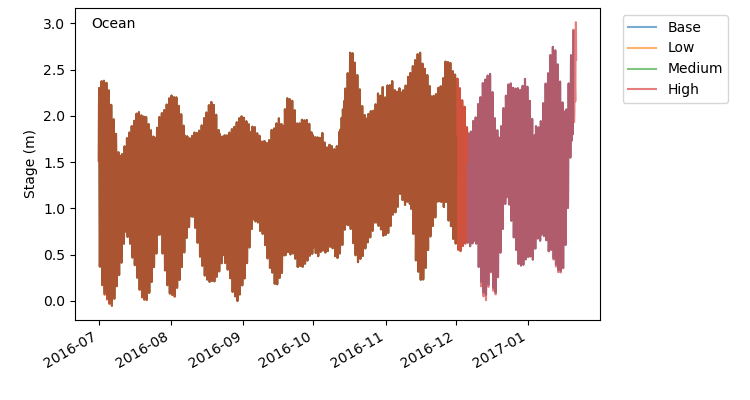

<IPython.core.display.Javascript object>


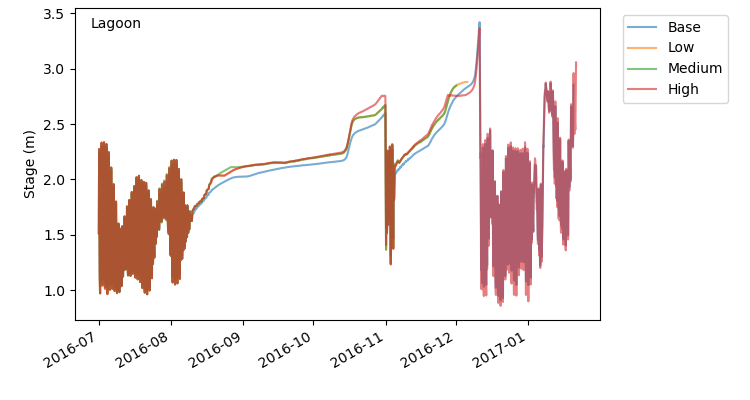

<IPython.core.display.Javascript object>


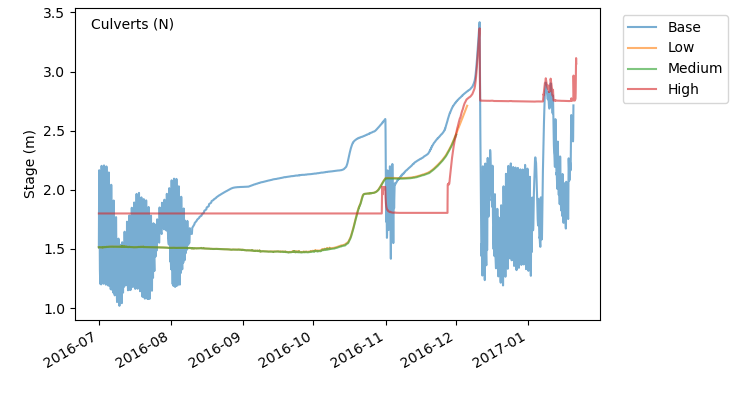

<IPython.core.display.Javascript object>


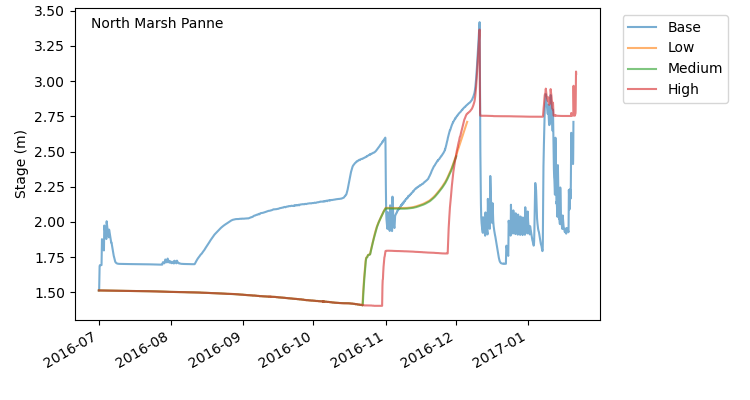

<IPython.core.display.Javascript object>


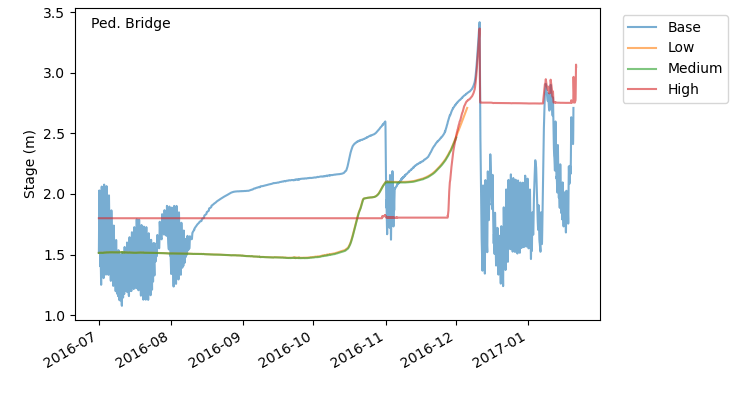

In [24]:
for station,label in stage_stations:
    fig_waterlevel_bystation_timeseries(runs,station,label)
    #fig_waterlevel_discharge_bystation_timeseries(runs,station,label)

<IPython.core.display.Javascript object>


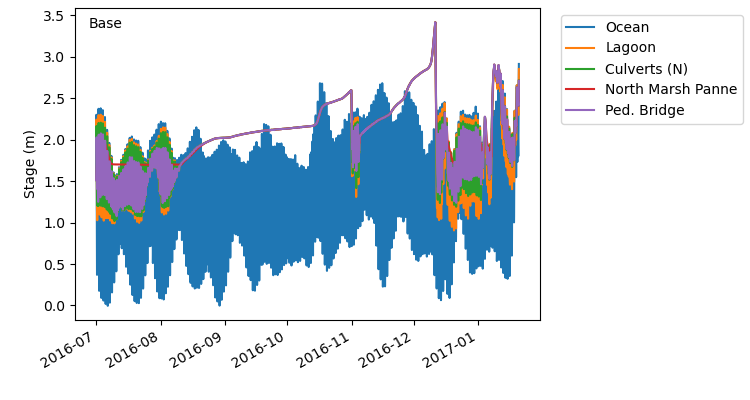

<IPython.core.display.Javascript object>


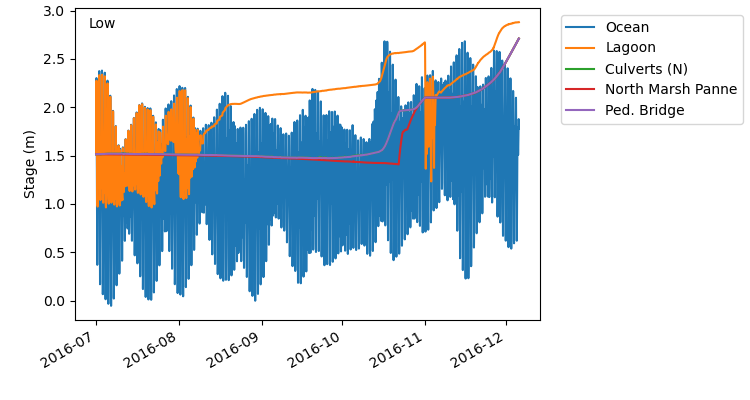

<IPython.core.display.Javascript object>


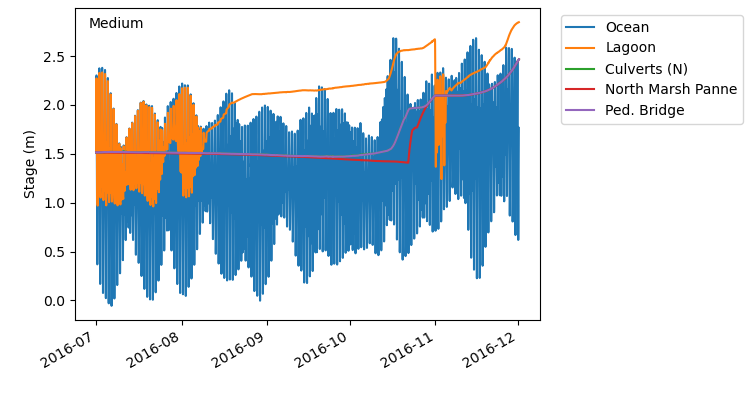

<IPython.core.display.Javascript object>


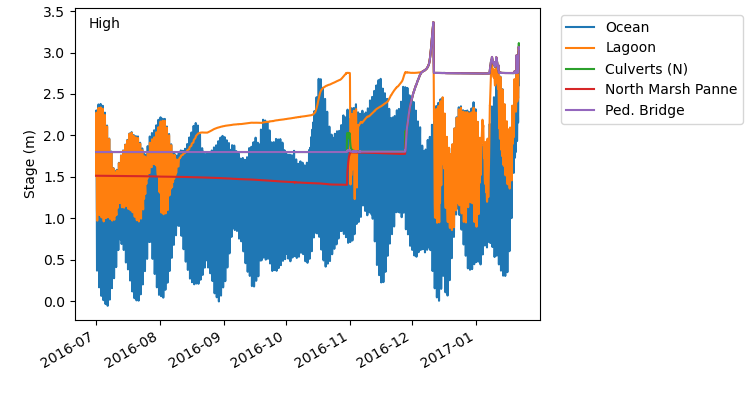

In [25]:
for _,rec in runs.iterrows():
    fig=fig_waterlevel_timeseries(rec) 
    fig.savefig(os.path.join(fig_dir,f'stage-timeseries-2016-{rec['name']}.png'),
                dpi=150)

In [26]:
plt.close('all')

Tidal Analysis
--

Bed stress

For bed stress, probably best to choose a day and re-run with half-hour output. Choose
2016-08-03 to 2016-08-05. Restarts are every 10 days, with one falling on 2016-08-04.

Tidal prism



In [6]:
# Start with 2D runs
six.moves.reload_module(run_database)
all_runs=run_database.all_runs
if 1:
    tidal_runs=all_runs[ (all_runs.layers==100) & (all_runs.period=='2016tidal')].copy()
    tidal_runs['name']=tidal_runs.scen.map({0:'Base',1:'Low',2:'Medium',3:'High'})
else:
    # some of these have a -v001, but does not include the tidal re-run
    tidal_runs=pd.DataFrame([
        dict(name='Base',run_dir='data_2016_2d_asbuilt_impaired/flowfmrtidal.mdu'),
        dict(name='Low', run_dir='data_2016_2d_asbuilt_impaired_scen1/flowfmrtidal.mdu'),
        dict(name='Medium',run_dir='data_2016_2d_asbuilt_impaired_scen2/flowfmrtidal.mdu'),
        dict(name='High',run_dir='data_2016_2d_asbuilt_impaired_scen3/flowfmrtidal.mdu')
    ])
tidal_runs

run_dir  scen  layers  \
22  data_2016long_3d_asbuilt_impaired_scen0_l100-v...     0     100   
23  data_2016long_3d_asbuilt_impaired_scen1_l100-v...     1     100   
24  data_2016long_3d_asbuilt_impaired_scen2_l100-v...     2     100   
25  data_2016long_3d_asbuilt_impaired_scen3_l100-v...     3     100   

       period     status     flows comments  slr    name  
22  2016tidal  completed  impaired      NaN  NaN    Base  
23  2016tidal  completed  impaired      NaN  NaN     Low  
24  2016tidal  completed  impaired      NaN  NaN  Medium  
25  2016tidal  completed  impaired      NaN  NaN    High

In [7]:
tidal_runs['model']=tidal_runs.run_dir.apply(lambda rd: dfm.DFlowModel.load(rd))

<IPython.core.display.Javascript object>


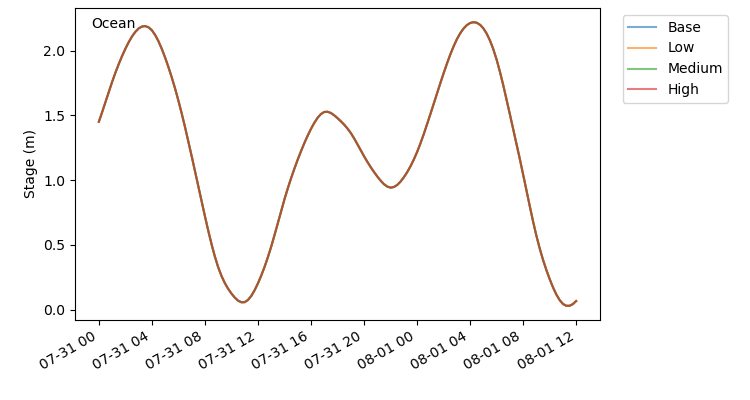

<IPython.core.display.Javascript object>


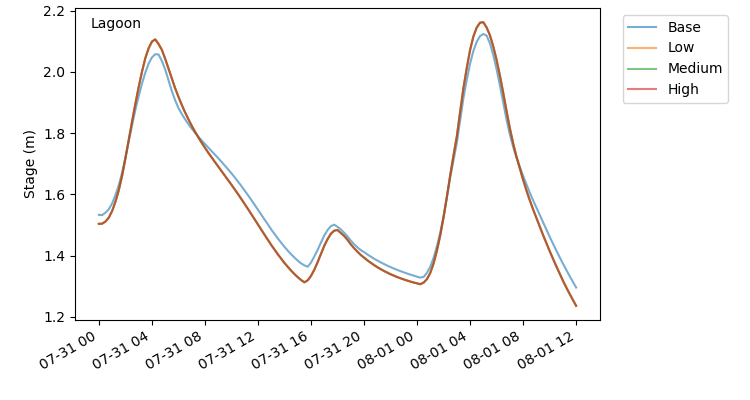

<IPython.core.display.Javascript object>


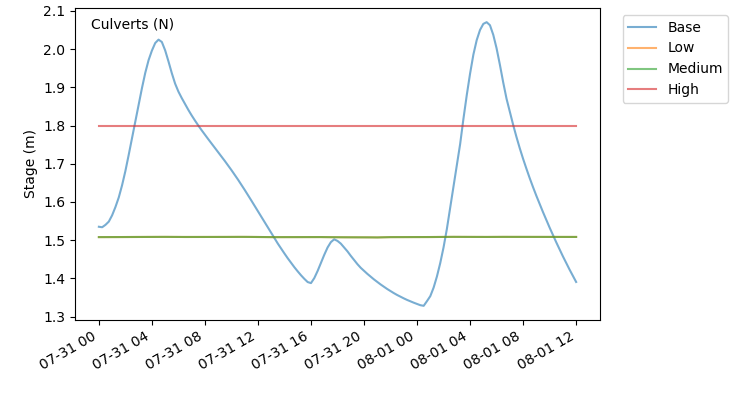

<IPython.core.display.Javascript object>


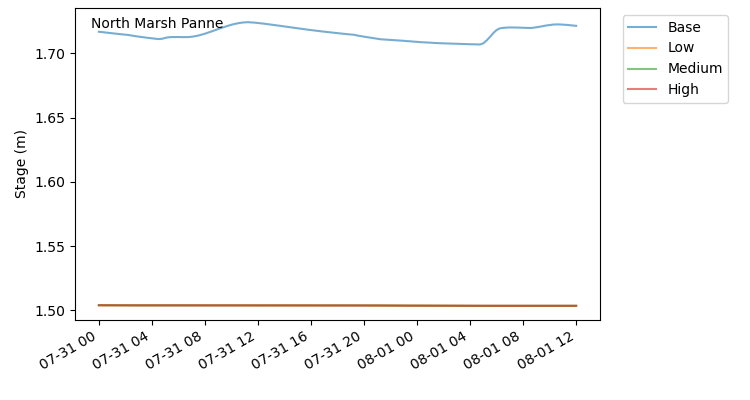

<IPython.core.display.Javascript object>


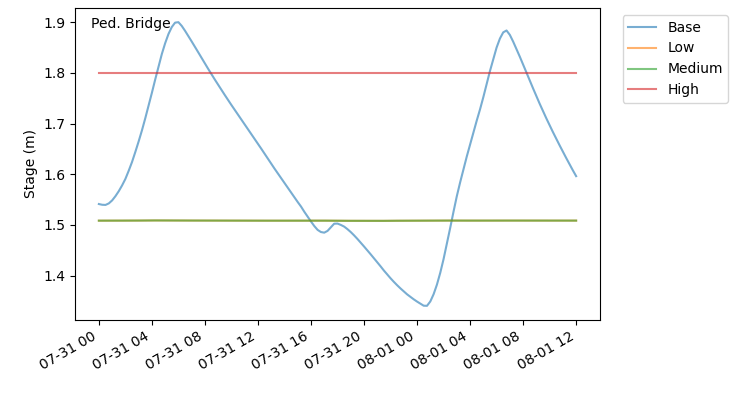

In [13]:
for station,label in stage_stations:
    fig_waterlevel_bystation_timeseries(tidal_runs,station,label)
    #fig_waterlevel_discharge_bystation_timeseries(runs,station,label)
    fig.savefig(os.path.join(fig_dir,f'tidal36h-stage-timeseries-2016-{station}.png'),
                dpi=150)

<IPython.core.display.Javascript object>


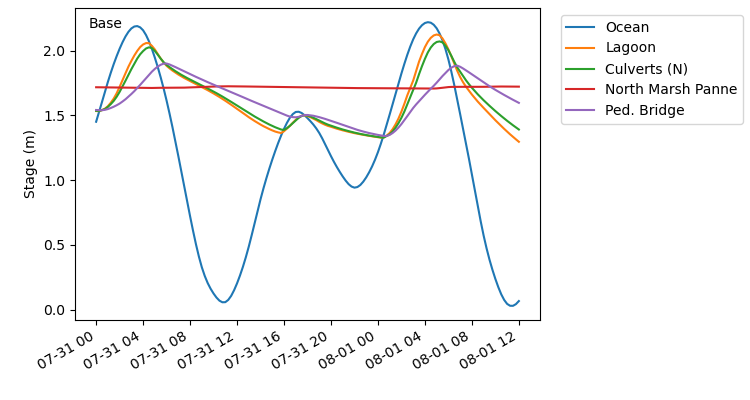

<IPython.core.display.Javascript object>


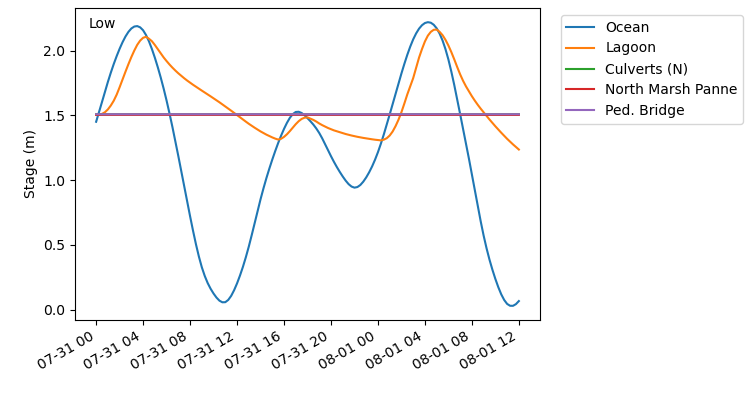

<IPython.core.display.Javascript object>


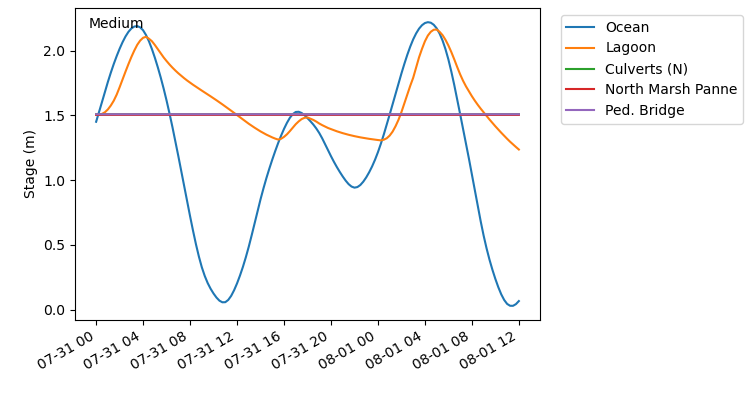

<IPython.core.display.Javascript object>


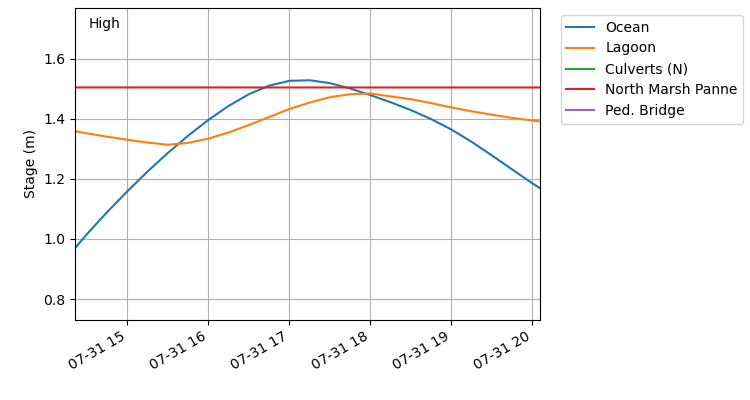

In [11]:
for _,rec in tidal_runs.iterrows():
    fig=fig_waterlevel_timeseries(rec) 
    fig.savefig(os.path.join(fig_dir,f'tidal36h-stage-timeseries-2016-{rec['name']}.png'),
                dpi=150)

In [14]:
# Choose an ebb period and a flood period

# For the older runs:
#ebb_period=[np.datetime64('2016-08-04 06:30:00'),
#            np.datetime64('2016-08-04 13:30:00')]
#flood_period=[np.datetime64('2016-08-04 13:30:00'),
#              np.datetime64('2016-08-04 20:00:00')]

# For tidal runs based on 2016long:
ebb_period=[np.datetime64('2016-07-31 03:30:00'), # large ebb.
            np.datetime64('2016-07-31 11:00:00')]
flood_period=[np.datetime64('2016-07-31 11:00:00'),
              np.datetime64('2016-07-31 17:00:00')]


In [40]:
ebb_sels=[]
flood_sels=[]
grid=None

for _,rec in tidal_runs.iterrows():
    ds=rec['model'].map_dataset(grid=grid)
    grid=grid or ds.grid # so everybody matches the same grid
    ebb_sels.append( (ebb_period[0]<=ds.time.values)&(ds.time.values<=ebb_period[1]) )
    flood_sels.append( (flood_period[0]<=ds.time.values)&(ds.time.values<=flood_period[1]) )

tidal_runs['ebb_sel']=ebb_sels
tidal_runs['flood_sel']=flood_sels

<IPython.core.display.Javascript object>


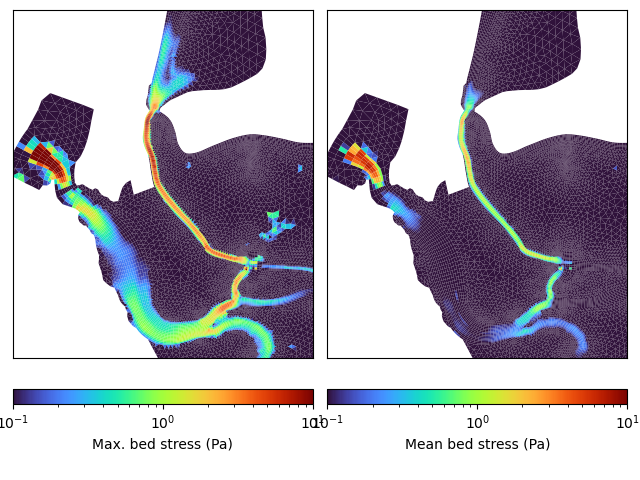

<IPython.core.display.Javascript object>


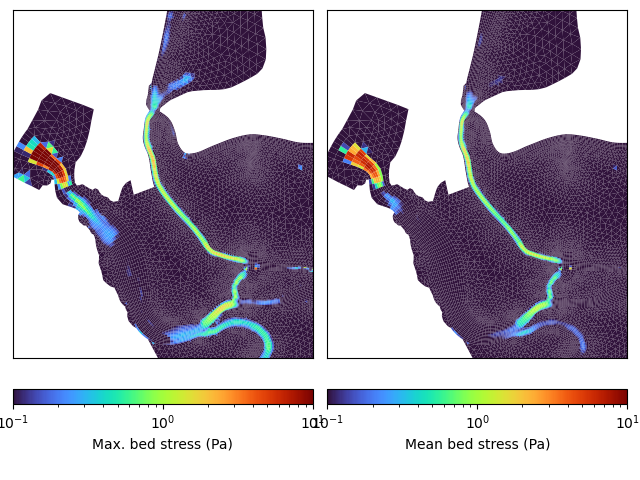

<IPython.core.display.Javascript object>


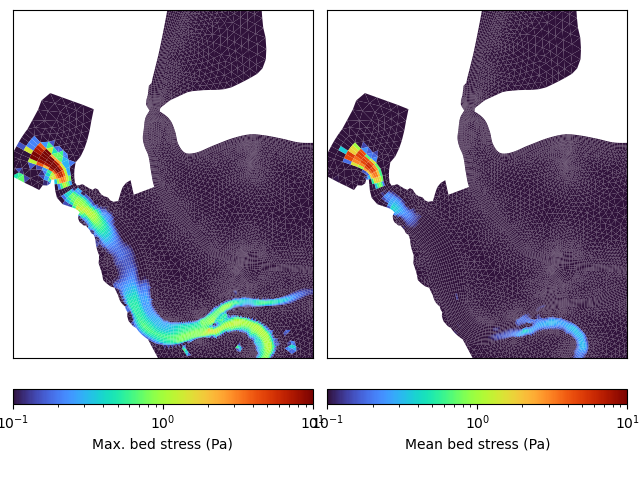

<IPython.core.display.Javascript object>


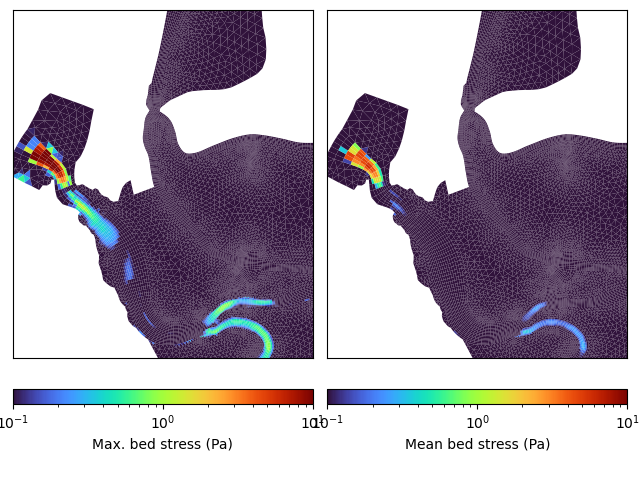

<IPython.core.display.Javascript object>


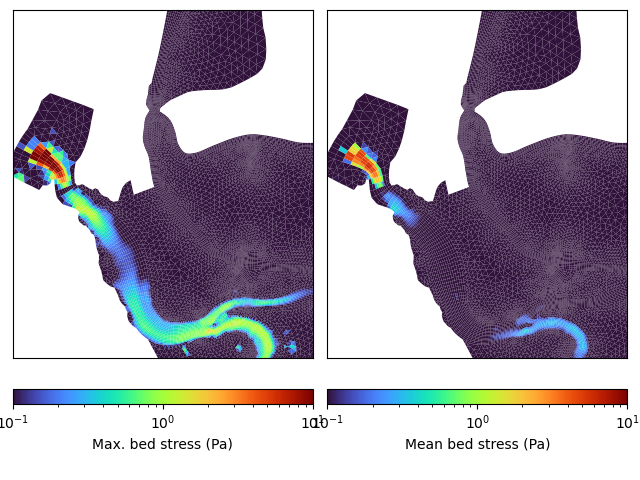

<IPython.core.display.Javascript object>


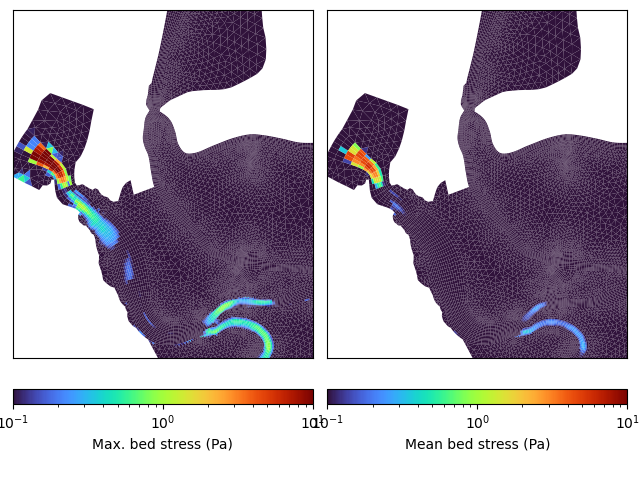

<IPython.core.display.Javascript object>


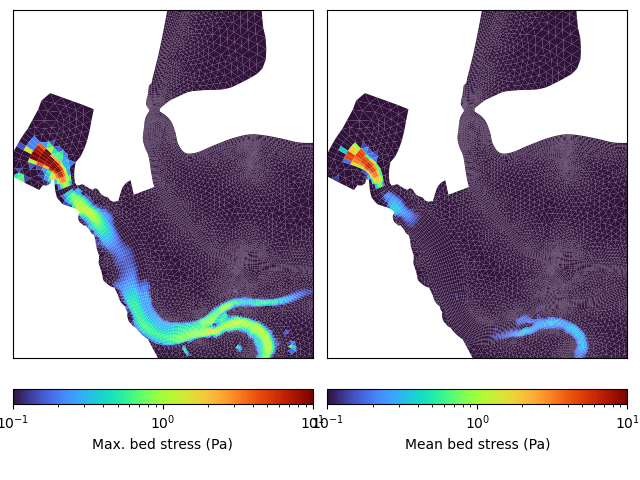

<IPython.core.display.Javascript object>


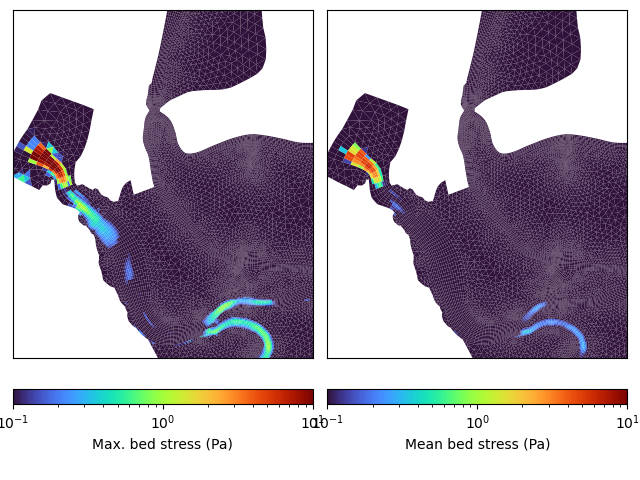

In [41]:
# mean and max bed stress for each of the runs, for flood and ebb
from matplotlib import colors
zoom=[552085, 552647.,4124191, 4125112]


for _,rec in tidal_runs.iterrows():
    ds=rec['model'].map_dataset()

    for sel,period_name in [ (rec['ebb_sel'],'ebb'),
                             (rec['flood_sel'],'flood')]:
        
        tau=ds['mesh2d_taus'].isel(time=sel).values
        tau_max=np.nanmax(tau, axis=0)
        tau_mean=np.mean(tau,axis=0)
        fig,axs=plt.subplots(1,2)
        for ax,vals,label in zip(axs,
                                  [tau_max,tau_mean],
                                  ['Max. bed stress (Pa)','Mean bed stress (Pa)']):
            ax.set_adjustable('datalim')
            ax.xaxis.set_visible(0)
            ax.yaxis.set_visible(0)

            #ccoll=ds.grid.plot_cells(values=vals,cmap='turbo',ax=ax)
            #ccoll.set_clim([0,10])
            ccoll=ds.grid.plot_cells(values=vals.clip(0.1),cmap='turbo',ax=ax,norm=colors.LogNorm())
            ccoll.set_clim([0.1,10])

            plt.colorbar(ccoll,ax=ax,label=label,pad=0.07,orientation='horizontal')
            ax.axis(zoom)
        fig.subplots_adjust(left=0.02,right=0.98,top=0.98,bottom=0.05,wspace=0.05,hspace=0.05)
        fig.savefig(os.path.join(fig_dir,f'bed_stress-{rec['name']}-{period_name}.png'),dpi=200)
    

Skip base==base


<IPython.core.display.Javascript object>


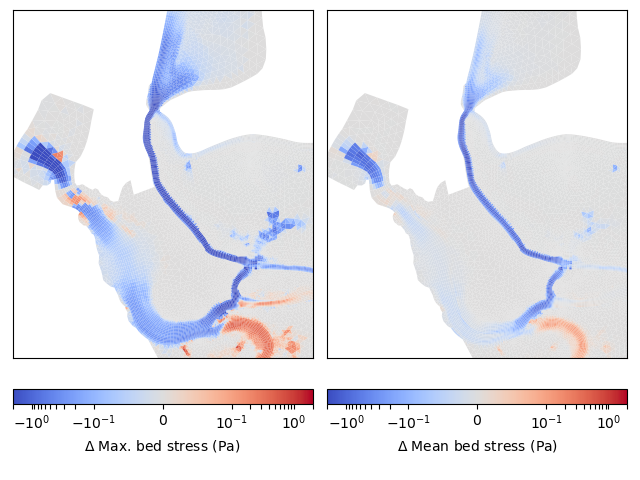

<IPython.core.display.Javascript object>


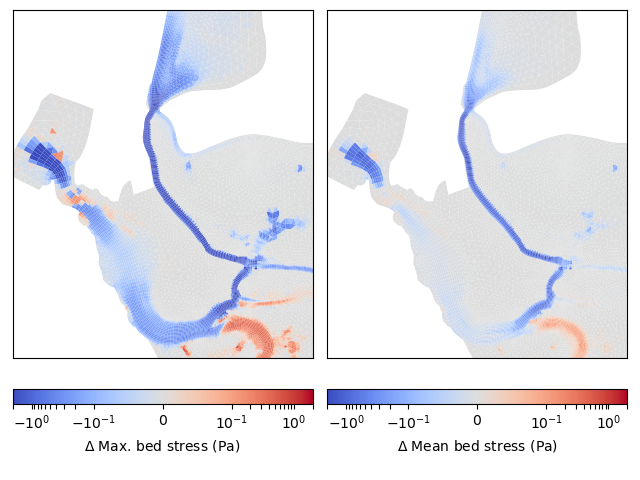

<IPython.core.display.Javascript object>


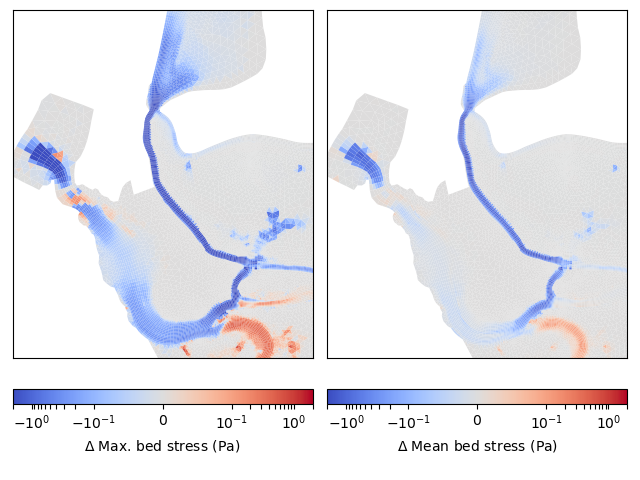

Skip base==base


/home/rustyh/miniconda3/envs/general/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


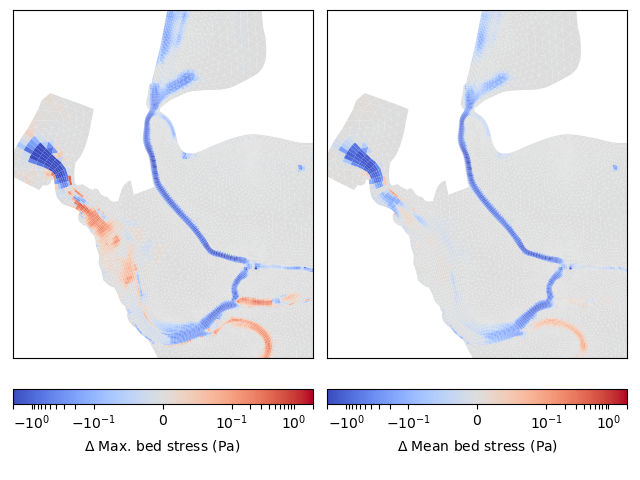

<IPython.core.display.Javascript object>


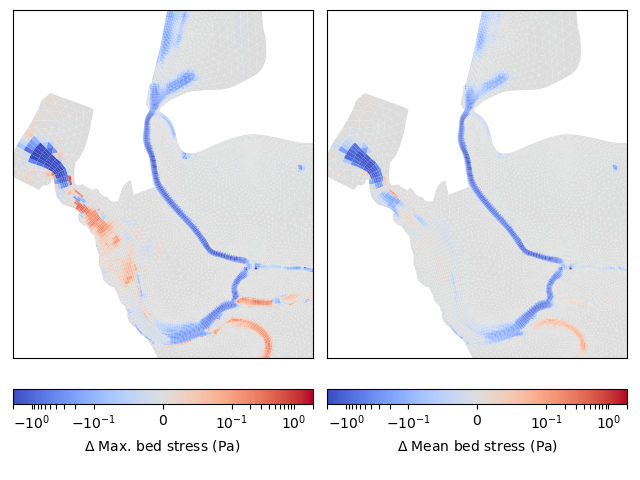

<IPython.core.display.Javascript object>


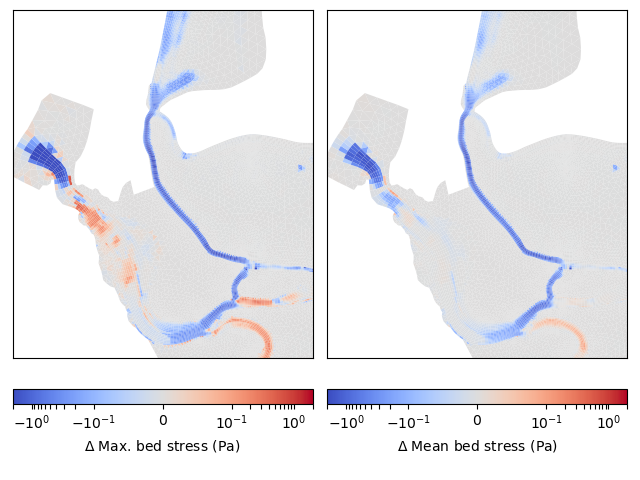

In [42]:
# Compare mean bed stress, per tidal phase, between each scenario
# and the base

zoom=[552085, 552647.,4124191, 4125112]

ds_base=tidal_runs.model.values[0].map_dataset()
ebb_sel_base=tidal_runs.ebb_sel.values[0]
flood_sel_base=tidal_runs.flood_sel.values[0]
tau_base=ds_base['mesh2d_taus']


for sel,period_name in [ (rec['ebb_sel'],'ebb'),
                         (rec['flood_sel'],'flood')]:
    if period_name=='ebb':
        tau=ds_base['mesh2d_taus'].isel(time=ebb_sel_base).values
    elif period_name=='flood':
        tau=ds_base['mesh2d_taus'].isel(time=flood_sel_base).values
        
    tau_max_base =np.nanmax(tau, axis=0)
    tau_mean_base=np.mean(tau,axis=0)
    
    for _,rec in tidal_runs.iterrows():
        ds=rec['model'].map_dataset()
        if ds==ds_base:
            print("Skip base==base")
            continue
        
        tau=ds['mesh2d_taus'].isel(time=sel).values
        tau_max=np.nanmax(tau, axis=0)
        tau_mean=np.mean(tau,axis=0)
        fig,axs=plt.subplots(1,2)
        for ax,vals,label in zip(axs,
                                 [tau_max-tau_max_base,
                                  tau_mean-tau_mean_base],
                                 [r'$\Delta$ Max. bed stress (Pa)',
                                  r'$\Delta$ Mean bed stress (Pa)']):
            ax.set_adjustable('datalim')
            ax.xaxis.set_visible(0)
            ax.yaxis.set_visible(0)

            ccoll=ds.grid.plot_cells(values=vals,cmap='coolwarm',ax=ax,
                                    norm=colors.SymLogNorm(0.1,vmin=-5,vmax=5,base=10))
            ccoll.set_clim([-2,2])

            plt.colorbar(ccoll,ax=ax,label=label,pad=0.07,orientation='horizontal')
            ax.axis(zoom)
        fig.subplots_adjust(left=0.02,right=0.98,top=0.98,bottom=0.05,wspace=0.05,hspace=0.05)
        fig.savefig(os.path.join(fig_dir,f'bed_stress-diff-{rec['name']}-{period_name}.png'),dpi=200)
        

Tidal Prism Figures
---

Why are some prisms coming up negative? 
 * N Complex is flipped in the input.

In [93]:
# Given a time and a history dataset, extract the prism from each cross-section
his_ds=tidal_runs.model.values[0].his_dataset()
# manually nudge so that lagged sections still recover ebb
ebb_time=ebb_period[0]+(ebb_period[1]-ebb_period[0])/2 + np.timedelta64(1,'h')

In [94]:
section_flips=['n_complex_xs'] # who needs to be inverted due to gis feature

def extract_volumes(his_ds,mid_time):
    prism_ds=xr.Dataset()
    prism_ds['cross_section']=his_ds.cross_section

    volumes=[]
    durations=[]
    volumes2=[] # calculated from cumulative discharge
    volumes_tidal=[]
    t_starts=[]
    t_stops=[]
    
    for i,section in enumerate(his_ds.cross_section.values):
        #print(section)
        if section in section_flips:
            sgn=-1
        else:
            sgn=1
        flow=sgn*his_ds['cross_section_discharge'].isel(cross_section=i).values
        # use just the tidally varying portion to define tidal period.
        flow_anom=flow-flow.mean()
        ti_mid=np.searchsorted(his_ds.time.values,mid_time)
        flow_mid=flow_anom[ti_mid]
        ti_start=ti_mid
        while (flow_anom[ti_start-1]*flow_mid>0) and (ti_start>0): ti_start-=1
        ti_stop=ti_mid
        while (flow_anom[ti_stop]*flow_mid>0) and (ti_stop+1<len(flow)): ti_stop+=1
        t=his_ds.time.values
        dt=(t[2]-t[1])/np.timedelta64(1,'s')
        volume=flow[ti_start:ti_stop].sum() * dt
        volumes.append(volume)
        durations.append((t[ti_stop] - t[ti_start])/np.timedelta64(3600,'s'))
        Qnet=sgn*his_ds['cross_section_cumulative_discharge'].isel(cross_section=i).values
        volumes2.append(Qnet[ti_stop] - Qnet[ti_start])
        volumes_tidal.append( (flow_anom[ti_start:ti_stop]).sum()*dt)
        t_starts.append( t[ti_start])
        t_stops.append(t[ti_stop])

    prism_ds['volume']=('cross_section',),volumes
    prism_ds['volume'].attrs['units']='m3'
    prism_ds['vol_Qnet']=('cross_section',),volumes2
    prism_ds['vol_tidal']=('cross_section',),volumes_tidal
    prism_ds['duration_h']=('cross_section',),durations 
    prism_ds['t_start']=('cross_section',),t_starts
    prism_ds['t_stop'] =('cross_section',),t_stops
    return prism_ds

In [95]:
# Prism table:
# select and label cross sections
section_sel={'mouth_xs':'Mouth',
             'n_complex_xs':'NM Complex',
             'n_ditch_xs':'NM N Ditch',
             'n_pond_xs':'N Pond',
             'butano_lower_xs':'Butano Ck',
             'pesca_lower_xs':'Pescadero Ck'}

sec_station_sel={'butano_lower_xs':'bc1',
                 'mouth_xs':'mid_mouth', # upstream side
                 'n_ditch_xs':'nmc_down', # or nmc_up?
                 'n_complex_xs':'pch_up', # upstream side of culverts
                 'n_pond_xs':'npc',
                 'pesca_lower_xs':'pch_down' # not great
                }
prisms=[]
for _,row in tidal_runs.iterrows():
    ds=extract_volumes(row['model'].his_dataset(),ebb_time)
    ds['run']=(),row['name']
    prisms.append(ds)
prisms_ds=xr.concat(prisms,dim='run')
prisms=prisms_ds.to_dataframe()
pd.set_option('display.max_rows', 100)
prisms

cross_section_name  \
cross_section    run                                                         
mouth_xs         Base    b'mouth_xs                                    ...   
                 Low     b'mouth_xs                                    ...   
                 Medium  b'mouth_xs                                    ...   
                 High    b'mouth_xs                                    ...   
n_pond_xs        Base    b'n_pond_xs                                   ...   
                 Low     b'n_pond_xs                                   ...   
                 Medium  b'n_pond_xs                                   ...   
                 High    b'n_pond_xs                                   ...   
n_ditch_xs       Base    b'n_ditch_xs                                  ...   
                 Low     b'n_ditch_xs                                  ...   
                 Medium  b'n_ditch_xs                                  ...   
                 High    b'n_ditch_xs                                  ...   
n_complex_xs     Base    b'n_complex_xs                                ...   
                 Low     b'n_complex_xs                                ...   
                 Medium  b'n_complex_xs                                ...   
                 High    b'n_complex_xs                                ...   
pesca_mid_xs     Base    b'pesca_mid_xs                                ...   
                 Low     b'pesca_mid_xs                                ...   
                 Medium  b'pesca_mid_xs                                ...   
                 High    b'pesca_mid_xs                                ...   
butano_lower_xs  Base    b'butano_lower_xs                             ...   
                 Low     b'butano_lower_xs                             ...   
                 Medium  b'butano_lower_xs                             ...   
                 High    b'butano_lower_xs                             ...   
pesca_lower_xs   Base    b'pesca_lower_xs                              ...   
                 Low     b'pesca_lower_xs                              ...   
                 Medium  b'pesca_lower_xs                              ...   
                 High    b'pesca_lower_xs                              ...   
pesca_bc_xs      Base    b'pesca_bc_xs                                 ...   
                 Low     b'pesca_bc_xs                                 ...   
                 Medium  b'pesca_bc_xs                                 ...   
                 High    b'pesca_bc_xs                                 ...   
butano_bc_xs     Base    b'butano_bc_xs                                ...   
                 Low     b'butano_bc_xs                                ...   
                 Medium  b'butano_bc_xs                                ...   
                 High    b'butano_bc_xs                                ...   
butano_mid_xs    Base    b'butano_mid_xs                               ...   
                 Low     b'butano_mid_xs                               ...   
                 Medium  b'butano_mid_xs                               ...   
                 High    b'butano_mid_xs                               ...   
pesca_rndhill    Base    b'pesca_rndhill                               ...   
                 Low     b'pesca_rndhill                               ...   
                 Medium  b'pesca_rndhill                               ...   
                 High    b'pesca_rndhill                               ...   
pesca_upper_xs   Base    b'pesca_upper_xs                              ...   
                 Low     b'pesca_upper_xs                              ...   
                 Medium  b'pesca_upper_xs                              ...   
                 High    b'pesca_upper_xs                              ...   
pesca_top_xs     Base    b'pesca_top_xs                                ...   
                 Low     b'pesca_top_xs                                ...   


In [96]:
df=prisms['volume'].unstack().reset_index()
df=df[ df.cross_section.isin(section_sel)].copy()

df['Cross section']=df['cross_section'].map(section_sel)

df=df.set_index('Cross section')
del df['cross_section']
df.to_csv(os.path.join(fig_dir,"ebb-prisms.csv"))

# Just for display:
for col in df.columns:
    df[col]=df[col].apply(lambda s: "%.0f"%s)
df

run              Base    High     Low  Medium
Cross section                                
Butano Ck       50239   51831   51821   51841
Mouth          161883  150096  149895  149899
NM Complex      41329       0      -0      -0
NM N Ditch       5165       0      -0      -0
N Pond          32155       0       1       1
Pescadero Ck    76522   56978   56996   57033

A little confusing.  How is it that at the mouth there is only 11e3 m3 more
prism in the base case, but the other cases are missing 41e3 of NM complex
prism?
They have only 1e3 more Butano prism.
It is somewhat telling that while Base has 41e3 more NM Complex prism,
the other cases compensate with 21e3 (Delta NMC - Delta pescadero ck) more
prism along Pescdero. So presumably they also have more prism in and around the
lagoon.

NB: NM N Ditch is actually over 17+h, because the flow does not
reverse for the little flood.

<IPython.core.display.Javascript object>


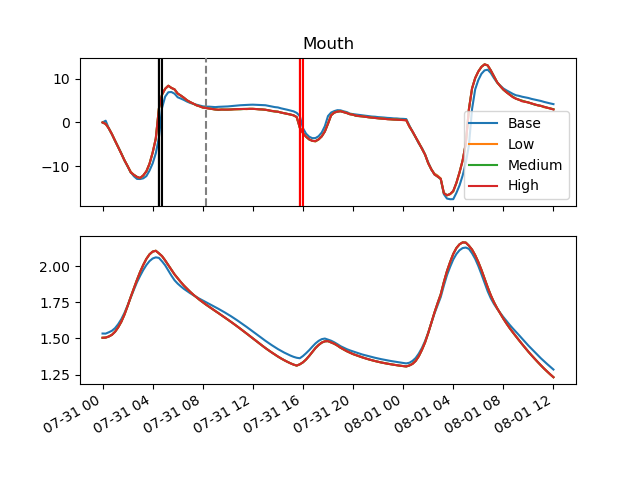

<IPython.core.display.Javascript object>


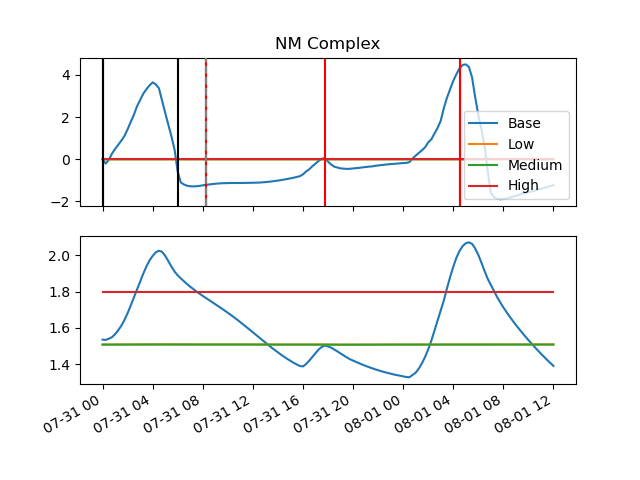

<IPython.core.display.Javascript object>


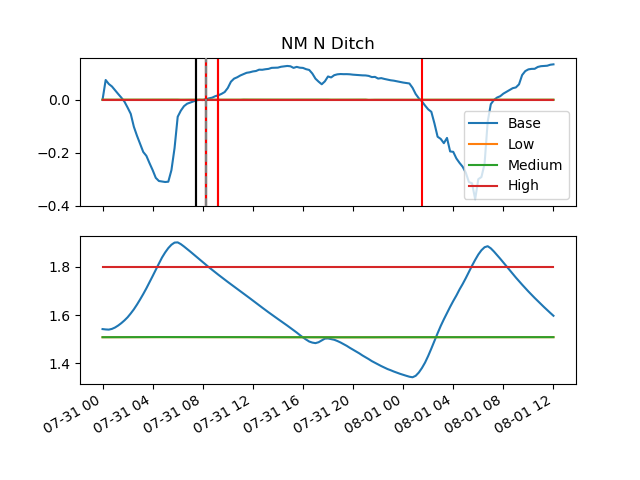

<IPython.core.display.Javascript object>


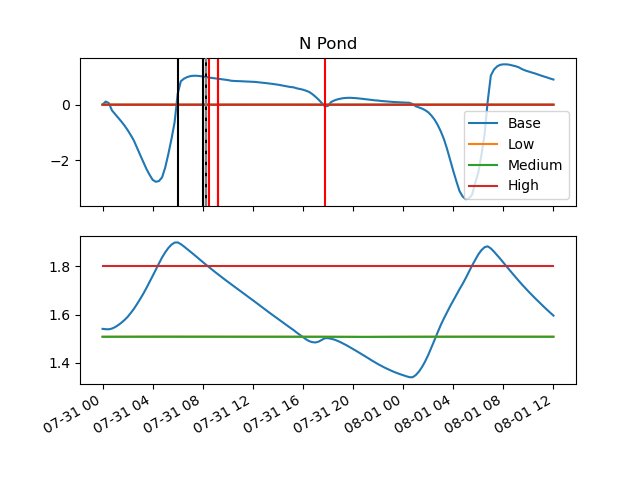

<IPython.core.display.Javascript object>


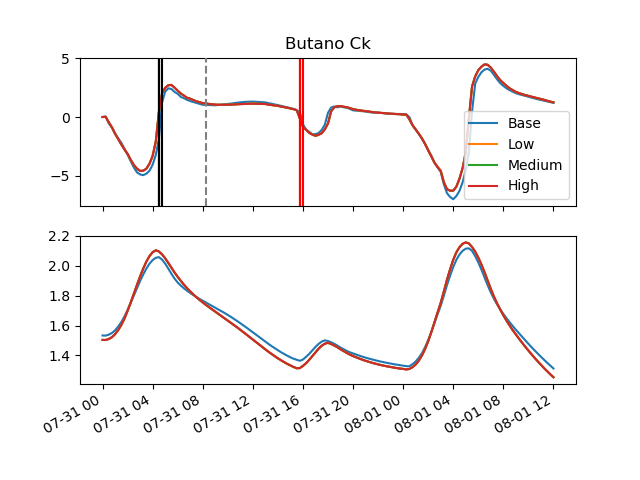

<IPython.core.display.Javascript object>


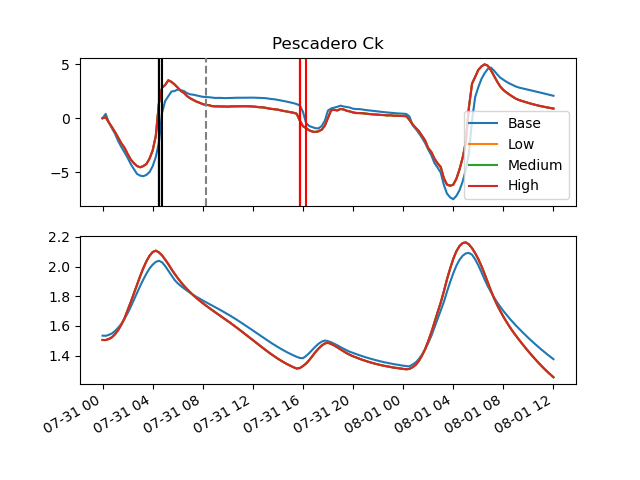

In [97]:
# Troubleshooting/visualizing the tide that went into tidal prism.
# Mouth is okay
# NM Complex is messy -- but it might be okay for Base, and just 
#  flipped. Fixed well enough.
# NM N Ditch is much better, though it still rolls over the
# actual reversal.
# N Pond okay, it's just roughly 0 for everything but base.
# Pescadero Ok.

for sec in section_sel:
    #sec='butano_lower_xs'
    stn=sec_station_sel[sec]

    fig,(ax,ax_eta)=plt.subplots(2,1,sharex=True)

    ax.axvline(ebb_time,color='0.5',ls='--',zorder=3)
    for _,row in tidal_runs.iterrows():
        his=row['model'].his_dataset()
        ax.plot(his.time, his.cross_section_discharge.sel(cross_section=sec),
                label=row['name'])
        ax_eta.plot(his.time, his.waterlevel.sel(stations=stn),
                    label=row['name'])

    secs_ds=prisms_ds.sel(cross_section=sec)
    for t_start in secs_ds.t_start.values:
        ax.axvline(t_start,color='k')
    for t_stop in secs_ds.t_stop.values:
        ax.axvline(t_stop,color='r')

    ax.legend(loc='lower right')
    ax.set_title(section_sel[sec])
    fig.autofmt_xdate()

Freshening
----

Time for depth-averaged salinity to reach 5ppt, after closure.

In [27]:
runs

run_dir  scen  layers    period  \
0  data_2016long_3d_asbuilt_impaired_scen0_l100-v026     0     100  2016long   
1  data_2016long_3d_asbuilt_impaired_scen1_l100-v003     1     100  2016long   
2  data_2016long_3d_asbuilt_impaired_scen2_l100-v006     2     100  2016long   
3  data_2016long_3d_asbuilt_impaired_scen3_l100-v009     3     100  2016long   

    status     flows comments  slr    name  \
0  running  impaired      NaN  NaN    Base   
1  crashed  impaired      NaN  NaN     Low   
2  running  impaired      NaN  NaN  Medium   
3  stopped  impaired      NaN  NaN    High   

                                               model  \
0  <stompy.model.delft.dflow_model.DFlowModel obj...   
1  <stompy.model.delft.dflow_model.DFlowModel obj...   
2  <stompy.model.delft.dflow_model.DFlowModel obj...   
3  <stompy.model.delft.dflow_model.DFlowModel obj...   

                                                 his  
0  [FlowElem_xcc, FlowElem_ycc, FlowElem_zcc, Flo...  
1  [FlowElem_xcc, FlowElem_ycc, FlowElem_zcc, Flo...  
2  [FlowElem_xcc, FlowElem_ycc, FlowElem_zcc, Flo...  
3  [FlowElem_xcc, FlowElem_ycc, FlowElem_zcc, Flo...

In [28]:
fresh_runs=runs 
#fresh_runs['model']=fresh_runs.run_dir.apply(lambda rd: dfm.DFlowModel.load(rd))
#fresh_runs['his']=fresh_runs.model.apply(lambda mod: mod.his_dataset())

In [29]:
# First, just use the map output
for _,row in fresh_runs.iterrows():
    model=row['model']
    mds=model.map_dataset()
    break
    

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)


<IPython.core.display.Javascript object>


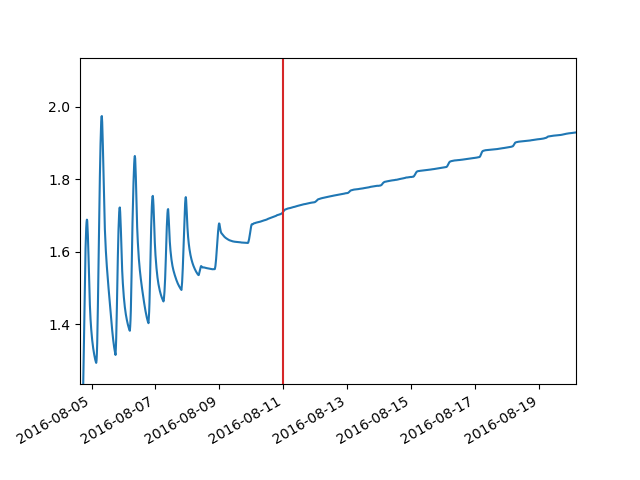

In [30]:
# When did it close?  Hopefully all of the runs will use the same starting
# time, so we can reuse the closure timing
# 8-09 might be closer?

t_close=np.datetime64("2016-08-11 00:00")

nck=row['his'].waterlevel.sel(stations='nck')
fig,ax=plt.subplots()
ax.plot(nck.time, nck)
ax.axvline(t_close,color='tab:red')
fig.autofmt_xdate()

In [56]:
from stompy.grid import ugrid
six.moves.reload_module(ugrid)

def s_davg(mds,ti):
    snap=mds.isel(time=ti)
    salt=snap['mesh2d_sa1'].values
    
    ug=ugrid.UgridXr(snap,layer_dim='mesh2d_nLayers',face_eta_vname='mesh2d_s1',
                     layer_vname='mesh2d_layer_z')
    weights=ug.vertical_averaging_weights(ztop=0,zbottom=0)
    s_davg=np.nansum(weights*salt,axis=1)
    dry=np.all(np.isnan(weights),axis=1)
    s_davg[dry]=np.nan
    return s_davg

def calc_days_to_freshen(mds,t_close,s_thresh=5.0):
    ti_close=np.searchsorted(mds.time.values,t_close)
    
    t_fresh=np.nan*np.ones(mds.grid.Ncells())
    time_vals=mds.time.values
    t0=time_vals[ti_close]

    for ti in range(ti_close,mds.dims['time']):
        print(f"{ti}/{mds.dims['time']}", end='  ')    
        salt_i=s_davg(mds,ti)
        fresh=(salt_i<s_thresh) & np.isnan(t_fresh)
        t_fresh[fresh]=(time_vals[ti]-t0)/np.timedelta64(86400,'s')
    return t_fresh

In [57]:
# Survey initial, depth-averaged salinity field
def figure_salinity(mod,t=t_close):
    mds=mod.map_dataset()
    ti_close=np.searchsorted(mds.time.values,t)
    salt0=s_davg(mds,ti_close)

    fig,ax=plt.subplots()
    ax.set_adjustable('datalim')
    ccoll=mds.grid.plot_cells(values=salt0,cmap='turbo',clim=[0,34])
    bgcoll=mds.grid.plot_cells(mask=np.isnan(salt0),color='0.85',zorder=-2,lw=0.5,edgecolor='face')

    ax.axis('off')
    plt.colorbar(ccoll,ax=ax,label='psu')
    return fig

Base


<IPython.core.display.Javascript object>


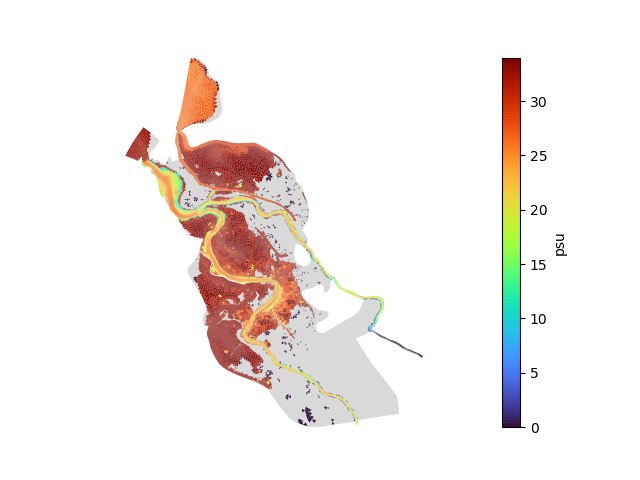

Low


<IPython.core.display.Javascript object>


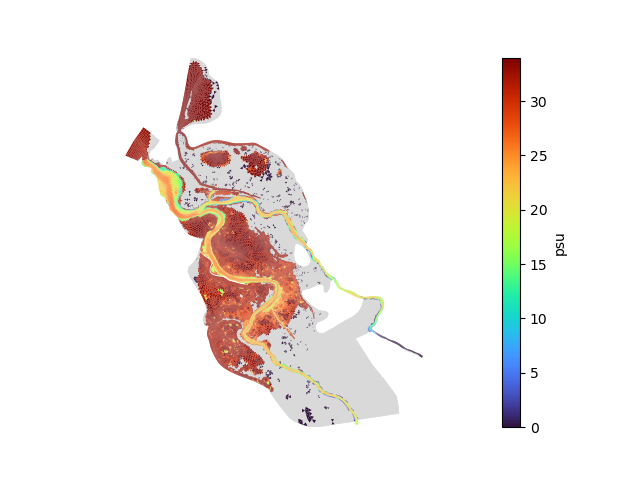

Medium


<IPython.core.display.Javascript object>


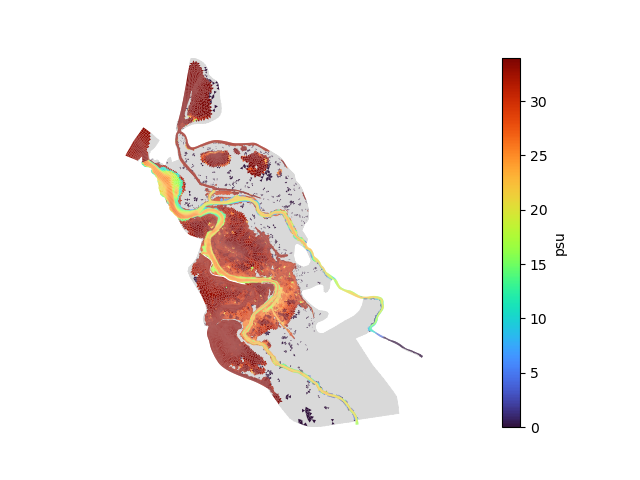

High


<IPython.core.display.Javascript object>


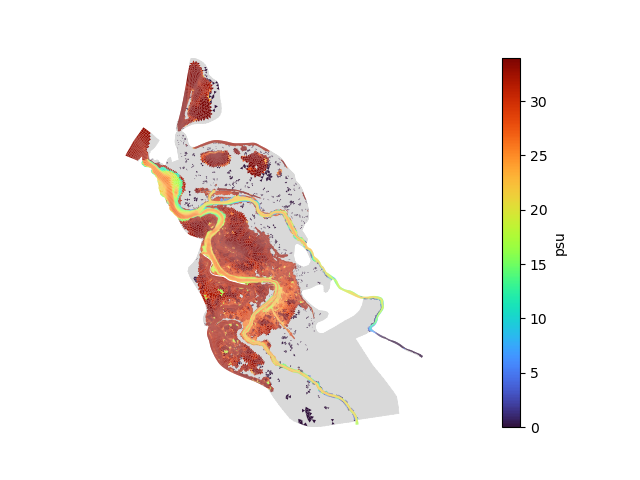

In [47]:
for _,run in fresh_runs.iterrows():
    print(run['name'])
    fig=figure_salinity(run['model'],t=t_close)
    fig.savefig(os.path.join(fig_dir,'salinity-davg-at_closure-{run["name"]}.png'),
               dpi=200)

In [58]:
def fig_freshen(rec,t_close=t_close):
    mod=rec['model']
    mds=mod.map_dataset()
    t_fresh=calc_days_to_freshen(mds,t_close)
    fig,ax=plt.subplots()
    ax.set_adjustable('datalim')
    mds.grid.plot_cells(color='0.65',zorder=-1)
    ccoll=mds.grid.plot_cells(values=t_fresh,mask=np.isfinite(t_fresh),cmap='turbo',zorder=1)
    ax.xaxis.set_visible(0)
    ax.yaxis.set_visible(0)
    fig.subplots_adjust(left=0.03,right=0.97,top=0.98,bottom=0.02)
    cax=fig.add_axes([0.05,0.08,0.03,0.45])
    plt.colorbar(ccoll,cax=cax,label="days")
    zoom=[551894., 553097.,4124145., 4125066.]
    ax.axis(zoom)
    return fig

In [ ]:
for _,rec in fresh_runs.iterrows():
    print(rec['name'])
    fig=fig_freshen(rec)
    fig.savefig(os.path.join(fig_dir,f"t_fresh-{rec['name']}-{rec['flows']}-{rec['period']}.png"),
                dpi=200)

Base
21/103  

/home/rustyh/src/stompy/stompy/grid/ugrid.py:826: RuntimeWarning: invalid value encountered in true_divide
  result = all_dz / np.sum(all_dz,axis=-1)[...,None]


22/103  23/103  24/103  25/103  26/103  27/103  28/103  29/103  30/103  31/103  32/103  33/103  34/103  35/103  36/103  37/103  38/103  39/103  40/103  41/103  42/103  43/103  44/103  45/103  46/103  47/103  48/103  49/103  50/103  51/103  52/103  53/103  54/103  55/103  56/103  57/103  58/103  59/103  60/103  61/103  62/103  63/103  64/103  65/103  66/103  67/103  68/103  69/103  70/103  71/103  72/103  73/103  74/103  75/103  76/103  77/103  78/103  79/103  80/103  81/103  82/103  83/103  84/103  85/103  86/103  87/103  88/103  89/103  90/103  91/103  92/103  93/103  94/103  95/103  96/103  97/103  98/103  99/103  100/103  101/103  102/103  

<IPython.core.display.Javascript object>

Low
21/80  22/80  23/80  24/80  25/80  26/80  27/80  28/80  29/80  30/80  31/80  32/80  33/80  34/80  35/80  36/80  37/80  38/80  39/80  40/80  41/80  42/80  43/80  44/80  45/80  46/80  

In [ ]:
HERE -- what's the next plot that makes sense with the existing runs? Maybe look at
the breach flow and where NM water goes?

Sea Level Rise
---

Show how the inlet depth is adjusted

In [112]:
run_slr='data_2013_3d_asbuilt_impaired_slr0.61m-v002'
run_base='data_2016long_3d_asbuilt_impaired-v003'

In [113]:
model_slr=dfm.DFlowModel.load(run_slr)
model_base=dfm.DFlowModel.load(run_base)

In [114]:
mds_slr=model_slr.map_dataset()
mds_base=model_base.map_dataset(grid=mds_slr.grid)

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing o

INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extra

<IPython.core.display.Javascript object>


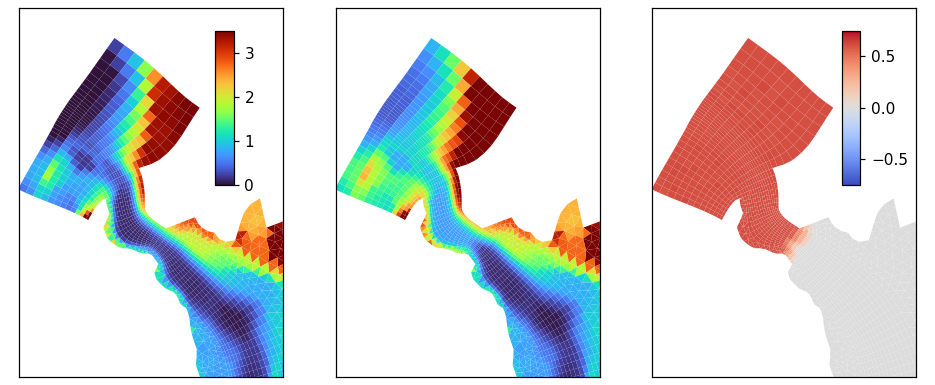

In [123]:
zoom_mouth=[551963., 552311., 4124425., 4124912.]
fig,axs=plt.subplots(1,3,figsize=[8.5,3.5])

plt.setp(axs,adjustable='datalim')

z_base=mds_base['mesh2d_flowelem_bl'].values
z_slr = mds_slr['mesh2d_flowelem_bl'].values
delta=z_slr-z_base

coll0=mds_base.grid.plot_cells(values=z_base,ax=axs[0],cmap='turbo')
coll1=mds_slr.grid.plot_cells(values=z_slr,ax=axs[1],cmap='turbo')
coll2=mds_slr.grid.plot_cells(values=delta,cmap='coolwarm',clim=[-0.75,0.75])

for coll in [coll0,coll1]:
    coll.set_clim([0,3.5])
    
for ax in axs:
    ax.axis(zoom_mouth)
    ax.xaxis.set_visible(0)
    ax.yaxis.set_visible(0)
    
fig.subplots_adjust(left=0.02,right=0.98,top=0.98,bottom=0.02)

cax0=fig.add_axes([0.23,0.52,0.02,0.40])
cax2=fig.add_axes([0.90,0.52,0.02,0.40])
plt.colorbar(coll0,cax=cax0)
plt.colorbar(coll2,cax=cax2)


In [120]:
axs[0].axis()

(551963.3399146893, 552311.8881788561, 4124425.0128392787, 4124912.9804091128)